# Transfer Learning

In [1]:
!pip install -q torch torchvision torchnet opencv-python

In [2]:
import copy
import math
import os
import shutil
import time

import cv2
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.nn.utils import weight_norm
import torch.optim as optim
from torch.optim import lr_scheduler
from torchnet import meter
import torchvision
from torchvision import datasets, models, transforms
import tqdm

In [3]:
def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[..., ::-1])
    else:
        plt.imshow(image)
    plt.axis("off")
    plt.show()

# Create model class

In [4]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding."
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.activation = nn.ReLU()
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.activation(out)

        return out


class BasicBlockV3(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlockV3, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.conv1 = conv3x3(inplanes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.activation = nn.ReLU()
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn3 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.bn1(x)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.activation = nn.ReLU()
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.activation(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.activation(out)

        return out


class HeadE(nn.Module):
    def __init__(self, input_size, emb_size):
        super(HeadE, self).__init__()
        self.fc = nn.Linear(input_size, emb_size)

    def forward(self, inputs):
        inputs = inputs.view(inputs.size(0), -1)
        x = self.fc(inputs)
        x = self.bn2(x)

        return x


class ResNetFR(nn.Module):
    def __init__(self, block, layers, emb_size=128, head_size=7 * 7 * 512,
                 preserve_resolution=True, **kwargs):
        self.inplanes = 64
        super(ResNetFR, self).__init__()
        if preserve_resolution:
            self.body = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1,
                          bias=False),
                nn.BatchNorm2d(64),
                nn.PReLU()
            )
        else:
            self.body = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                          bias=False),
                nn.BatchNorm2d(64),
                nn.PReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            )

        self.head_size = head_size
        self.emb_size = emb_size

        self.layer1 = self._make_layer(block, 64, layers[0], stride=2)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        if kwargs.get("emb_model", False):
            self.head = HeadE(self.head_size, self.emb_size)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def set_parameter_requires_grad(self, layers=set()):
        """
        Sets parameters from the heads listed in layers to requires_grad=True.
        Args:
            layers: Set  of name strings for heads to set requires_grad=True,
            e.g. {'pose_model'}.
        """
        if layers:
            for name, param in self.named_parameters():
                if name.split(".")[0] in layers:
                    param.requires_grad = True
                else:
                    param.requires_grad = False

    def set_parameter_to_train(self, layers=set()):
        """
        Sets parameters from the heads listed in layers to train mode.
        Args:
            layers: Set  of name strings for heads to set to train mode,
            e.g. {'pose_model'}.
        """
        model.eval()
        for layer in layers:
            head = getattr(self, layer)
            head.train()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = list()
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        device = x.device
        batch_size = x.shape[0]

        x = self.body(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if hasattr(self, "head"):
            embeddings = self.head(x)
        else:
            embeddings = torch.zeros(batch_size, self.emb_size).detach()

        return embeddings

In [5]:
def build_resnet(depth, **kwargs):
    if depth >= 101:
        block = Bottleneck
    else:
        block = BasicBlockV3

    if depth == 18:
        units = [2, 2, 2, 2]
    elif depth == 34:
        units = [3, 4, 6, 3]
    elif depth == 49:
        units = [3, 4, 14, 3]
    elif depth == 50:
        units = [3, 4, 14, 3]
    elif depth == 74:
        units = [3, 6, 24, 3]
    elif depth == 90:
        units = [3, 8, 30, 3]
    elif depth == 100:
        units = [3, 13, 30, 3]
    elif depth == 101:
        units = [3, 4, 23, 3]
    elif depth == 152:
        units = [3, 8, 36, 3]
    else:
        raise ValueError(
            f"No experiments done on num_layers {depth}, " \
            f"you can do it yourself."
        )

    model = ResNetFR(block, units, **kwargs)

    return model

# Create model

In [6]:
model_ft = build_resnet(100)

In [7]:
# Uncomment to see the error "'ResNetFR' object has no attribute 'head'".
# Because it really doesn't have that attribute!
# model_ft.head

# Create model with emb head

In [8]:
model_ft = build_resnet(100, emb_model=True)

In [9]:
# Now it's got a head:
model_ft.head

HeadE(
  (fc): Linear(in_features=25088, out_features=128, bias=True)
)

In [10]:
checkpoint = torch.load("fr.pth.tar", map_location="cpu")

In [11]:
model_ft.load_state_dict(checkpoint, strict=True)

<All keys matched successfully>

# Add head for gender prediction

In [12]:
class ResNeXtBottleneck(nn.Module):
    """
    RexNeXt bottleneck type C
    (https://github.com/facebookresearch/ResNeXt/blob/master/models/resnext.lua)
    """
    def __init__(self, in_channels, out_channels,
                 stride, cardinality, widen_factor):
        """
        Constructor.
        Args:
            in_channels: input channel dimensionality;
            out_channels: output channel dimensionality;
            stride: conv stride, replaces pooling layer;
            cardinality: num of convolution groups;
            widen_factor: factor to reduce the input dimensionality
                          before convolution.
        """
        super(ResNeXtBottleneck, self).__init__()
        D = cardinality * out_channels // widen_factor
        self.conv_reduce = nn.Conv2d(in_channels, D, kernel_size=1, stride=1,
                                     padding=0, bias=False)
        self.bn_reduce = nn.BatchNorm2d(D)
        self.conv_conv = nn.Conv2d(D, D, kernel_size=3, stride=stride,
                                   padding=1, groups=cardinality, bias=False)
        self.bn = nn.BatchNorm2d(D)
        self.conv_expand = nn.Conv2d(D, out_channels, kernel_size=1, stride=1,
                                     padding=0, bias=False)
        self.bn_expand = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut.add_module("shortcut_conv",
                                     nn.Conv2d(in_channels, out_channels,
                                               kernel_size=1, stride=stride,
                                               padding=0, bias=False))
            self.shortcut.add_module("shortcut_bn",
                                     nn.BatchNorm2d(out_channels))

    def forward(self, x):
        bottleneck = self.conv_reduce.forward(x)
        bottleneck = F.relu(self.bn_reduce.forward(bottleneck), inplace=True)
        bottleneck = self.conv_conv.forward(bottleneck)
        bottleneck = F.relu(self.bn.forward(bottleneck), inplace=True)
        bottleneck = self.conv_expand.forward(bottleneck)
        bottleneck = self.bn_expand.forward(bottleneck)
        residual = self.shortcut.forward(x)
        return F.relu(residual + bottleneck, inplace=True)


class ResidualTailNetwork(nn.Module):
    def __init__(self, n_classes=1, widen_factor=4):
        super(ResidualTailNetwork, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.block_depth = 3
        self.cardinality = 16
        self.widen_factor = widen_factor
        self.n_classes = n_classes

        self.stages = [64 * self.widen_factor,
                       128 * self.widen_factor,
                       256 * self.widen_factor]
        # self.depths = [2, 3, 4]
        self.depths = [3, 4]
        self.stage_1 = self.block("stage_1", self.stages[0], self.stages[1], 2)
        self.stage_2 = self.block("stage_2", self.stages[1], self.stages[2], 2)

        for key in self.state_dict():
            if key.split('.')[-1] == "weight":
                if "conv" in key:
                    init.kaiming_normal_(self.state_dict()[key],
                                         mode="fan_out")
                if "bn" in key:
                    self.state_dict()[key][...] = 1
            elif key.split('.')[-1] == "bias":
                self.state_dict()[key][...] = 0

        self.avgpool = nn.AvgPool2d(4)
        self.fc = nn.Linear(self.stages[-1], self.n_classes)
        if self.widen_factor == 1:
            self.fc = nn.Linear(self.stages[-1] * 4, self.n_classes) 

    def block(self, name, in_channels, out_channels, pool_stride=2):
        """
        Stack n bottleneck modules where n is inferred from the depth
        of the network.
        Args:
            name: string name of the current block;
            in_channels: number of input channels;
            out_channels: number of output channels;
            pool_stride: factor to reduce the spatial dimensionality
                         in the first bottleneck of the block.
        Returns: a Module consisting of n sequential bottlenecks.
        """
        block = nn.Sequential()
        for bottleneck in range(self.block_depth):
            name_ = "%s_bottleneck_%d" % (name, bottleneck)
            if bottleneck == 0:
                block.add_module(name_, ResNeXtBottleneck(
                    in_channels, out_channels, pool_stride,
                    self.cardinality, self.widen_factor))
            else:
                block.add_module(name_, ResNeXtBottleneck(
                    out_channels, out_channels, 1,
                    self.cardinality, self.widen_factor))

        return block

    def forward(self, x):
        x = self.stage_1.forward(x)
        x = self.stage_2.forward(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Add hew self.gender_model head, update the forward pass code

In [13]:
class ResNetFR(nn.Module):
    def __init__(self, block, layers, emb_size=128, head_size=7 * 7 * 512,
                 preserve_resolution=True, **kwargs):
        self.inplanes = 64
        super(ResNetFR, self).__init__()
        if preserve_resolution:
            self.body = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1,
                          bias=False),
                nn.BatchNorm2d(64),
                nn.PReLU()
            )
        else:
            self.body = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                          bias=False),
                nn.BatchNorm2d(64),
                nn.PReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            )

        self.head_size = head_size
        self.emb_size = emb_size
        self.gender_only = kwargs.get("gender_only", False)

        self.layer1 = self._make_layer(block, 64, layers[0], stride=2)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        if kwargs.get("emb_model", False):
            self.head = HeadE(self.head_size, self.emb_size)

        if kwargs.get("gender_model", False):
            self.gender_model = ResidualTailNetwork(widen_factor=4)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def set_parameter_requires_grad(self, layers=set()):
        """
        Sets parameters from the heads listed in layers to requires_grad=True.
        Args:
            layers: Set  of name strings for heads to set requires_grad=True,
            e.g. {'pose_model'}.
        """
        if layers:
            for name, param in self.named_parameters():
                if name.split('.')[0] in layers:
                    param.requires_grad = True
                else:
                    param.requires_grad = False

    def set_parameter_to_train(self, layers=set()):
        """
        Sets parameters from the heads listed in layers to train mode.
        Args:
            layers: Set  of name strings for heads to set to train mode,
            e.g. {'pose_model'}.
        """
        model.eval()
        for layer in layers:
            head = getattr(self, layer)
            head.train()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = list()
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        device = x.device
        batch_size = x.shape[0]

        x = self.body(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        #x = self.layer4(x)
        if hasattr(self, "gender_model"):
            male_proba = self.gender_model(x)
        else:
            male_proba = torch.empty(batch_size, 1)

        if self.gender_only:
            return male_proba

        x = self.layer4(x)

        if hasattr(self, "head"):
            embeddings = self.head(x)
        else:
            embeddings = torch.zeros(batch_size, self.emb_size).detach()

        return embeddings, male_proba

# Create model without emb head

In [14]:
model_ft = build_resnet(100, emb_model=False,
                        gender_model=True, gender_only=True)

In [15]:
model_ft.gender_model

ResidualTailNetwork(
  (relu): ReLU(inplace=True)
  (stage_1): Sequential(
    (stage_1_bottleneck_0): ResNeXtBottleneck(
      (conv_reduce): Conv2d(256, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn_reduce): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_conv): Conv2d(2048, 2048, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
      (bn): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_expand): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn_expand): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (shortcut_conv): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (shortcut_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (stage_1_bottleneck_1): ResNeXtBottleneck(
      (conv_red

In [16]:
checkpoint = torch.load("fr.pth.tar", map_location="cpu")

In [17]:
model_ft.load_state_dict(checkpoint, strict=False)

_IncompatibleKeys(missing_keys=['gender_model.stage_1.stage_1_bottleneck_0.conv_reduce.weight', 'gender_model.stage_1.stage_1_bottleneck_0.bn_reduce.weight', 'gender_model.stage_1.stage_1_bottleneck_0.bn_reduce.bias', 'gender_model.stage_1.stage_1_bottleneck_0.bn_reduce.running_mean', 'gender_model.stage_1.stage_1_bottleneck_0.bn_reduce.running_var', 'gender_model.stage_1.stage_1_bottleneck_0.conv_conv.weight', 'gender_model.stage_1.stage_1_bottleneck_0.bn.weight', 'gender_model.stage_1.stage_1_bottleneck_0.bn.bias', 'gender_model.stage_1.stage_1_bottleneck_0.bn.running_mean', 'gender_model.stage_1.stage_1_bottleneck_0.bn.running_var', 'gender_model.stage_1.stage_1_bottleneck_0.conv_expand.weight', 'gender_model.stage_1.stage_1_bottleneck_0.bn_expand.weight', 'gender_model.stage_1.stage_1_bottleneck_0.bn_expand.bias', 'gender_model.stage_1.stage_1_bottleneck_0.bn_expand.running_mean', 'gender_model.stage_1.stage_1_bottleneck_0.bn_expand.running_var', 'gender_model.stage_1.stage_1_bottl

# The model works with tensors of shape 3x3x112. Make sure it returns what we need

In [18]:
model_ft.eval()

ResNetFR(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (layer1): Sequential(
    (0): BasicBlockV3(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
   

In [19]:
input_tensor = torch.ones(100, 3, 112, 112)

In [20]:
out = model_ft(input_tensor)

In [21]:
len(out)

100

In [22]:
out.shape

torch.Size([100, 1])

# Useful functions

In [23]:
class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def save_checkpoint(state, is_best_gender=False,  filename="checkpoint"):
    torch.save(state, filename + ".pth.tar")
    if is_best_gender:
        shutil.copyfile(filename + ".pth.tar",
                        filename + "_best_gender.pth.tar")


def imshow(inp, title=None, figsize=(16, 9)):
    """Imshow for Tensor."""
    plt.figure(figsize=figsize)
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


def set_bn_eval(module):
    if isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
        module.eval()
          
def set_parameter_requires_grad(model, layers=set()):
    """
    Sets parameters from the heads listed in layers to requires_grad=True.
    Args:
        layers: Set  of name strings for heads to set requires_grad=True,
        e.g. {'pose_model'}.
    """
    model.eval()
    if layers:
        for name, param in model.named_parameters():
            if name.split('.')[0] in layers:
                param.requires_grad = True
            else:
                param.requires_grad = False


def set_parameter_to_train(model, layers=set()):
    """
    Sets parameters from the heads listed in layers to train mode.
    Args:
        layers: Set  of name strings for heads to set to train mode,
        e.g. {'pose_model'}.
    """
    model.eval()
    for layer in layers:
        head = getattr(model, layer)
        head.train()
        enable_running_stats(head)


def disable_running_stats(model):
    for module in model.modules():
        if hasattr(module, "track_running_stats"):
            module.track_running_stats = False


def enable_running_stats(model):
    for module in model.modules():
        if hasattr(module, "track_running_stats"):
            module.track_running_stats = True


def get_trainable_params(model):
    if hasattr(model, "module"):
        parameters = model.module.named_parameters()
    else:
        parameters = model.named_parameters()

    print ("Parameters to update:")
    params_to_update = []
    for name, param in parameters:
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
    return params_to_update

# Specify augmentations and load datasets

In [24]:
train_transforms = transforms.Compose([
        transforms.Resize(112),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(
            brightness=0.4,
            contrast=0.4,
            saturation=0.4
        ),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


val_transforms = transforms.Compose([
        transforms.Resize(112),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [25]:
train_folder = "gender_dataset/train/"
val_folder = "gender_dataset/val/"

In [26]:
train_dataset = torchvision.datasets.ImageFolder(train_folder,
                                                 train_transforms)

In [27]:
len(train_dataset)

9942

In [28]:
val_dataset = torchvision.datasets.ImageFolder(val_folder, val_transforms)

In [29]:
len(val_dataset)

2500

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=50,
                                               shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=50,
                                             shuffle=False, num_workers=4)

# Let's look at the samples

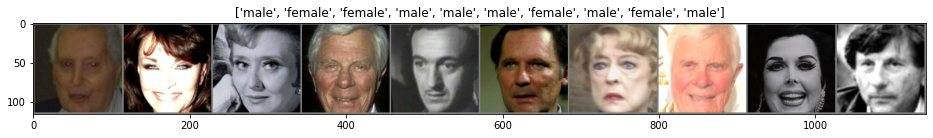

In [32]:
class_names = train_dataset.classes

# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:10], nrow=10)
imshow(out, title=[class_names[x] for x in classes[:10]])

# Train / Val functions

In [33]:
def train(train_loader, model, criterion, optimizer, epoch,
          trainable_params=["gender_model"], device="cuda", print_freq=10):
    # with NLL loss
    batch_time = AverageMeter()
    data_time = AverageMeter()
    avg_loss = AverageMeter()

    # switch to train mode
    model.train()
    model.to(device)

    # set only gender head to train
    set_parameter_requires_grad(model, set(trainable_params))
    set_parameter_to_train(model_ft, set(trainable_params))

    #set metrics
    gender_auc_mtr = meter.AUCMeter()

    end = time.time()
    for i, (input_tensor, gender_labels) in enumerate(tqdm.tqdm(train_loader)):
        # measure data loading time
        data_time.update(time.time() - end)

        input_tensor = input_tensor.to(device)
        gender_labels = gender_labels.float().to(device)

        # compute output
        gender_preds = model(input_tensor).squeeze(1)

        # gender + age
        gender_loss = criterion(gender_preds, gender_labels)

        avg_loss.update(gender_loss.item(), input_tensor.shape[0])

        # compute gradient and do optimizer step
        optimizer.zero_grad()
        gender_loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # update gender stats
        gender_auc_mtr.add(torch.sigmoid(gender_preds.detach()), gender_labels)

    train_gender_roc_auc, _, _= gender_auc_mtr.value()

    return train_gender_roc_auc, avg_loss

In [34]:
def validate(model, val_dataloader, gender_thresh=0.5, device="cuda"):
    gender_auc_mtr = meter.AUCMeter()
    gender_confusion_mtr = meter.ConfusionMeter(k=2)

    model.eval().to(device)
    running_loss = 0.0
    # we'll store filenames which we made mistakes on
    gender_mistakes = []
    male_index = val_dataloader.dataset.class_to_idx["male"]

    for inputs, genders in tqdm.tqdm(val_dataloader):
        inputs = inputs.to(device)
        gender_labels = genders.float().to(device)

        with torch.no_grad():
            gender_preds = model(inputs)

        gender_preds = torch.sigmoid(gender_preds)
        gender_preds_labels = gender_preds > gender_thresh

        gender_mistakes.extend(
            list(map(int, gender_preds_labels.flatten().long() != 
                          gender_labels.flatten().long()))
        )

        # update gender stats
        gender_auc_mtr.add(gender_preds, gender_labels)

        gender_confusion_mtr.add(
            torch.nn.functional.one_hot(gender_preds_labels.flatten().long(),
                                        num_classes=2),
            torch.nn.functional.one_hot(gender_labels.flatten().long(),
                                        num_classes=2)
        )

    val_gender_roc_auc, _, _= gender_auc_mtr.value()
    val_gender_confusion_matrix = gender_confusion_mtr.value()
    val_gender_acc = np.trace(val_gender_confusion_matrix) \
                     / np.sum(val_gender_confusion_matrix)
    return val_gender_roc_auc, val_gender_acc, \
           val_gender_confusion_matrix, gender_mistakes

# Let's freeze everything except for the head

In [35]:
# disable_running_stats(model_ft)
set_parameter_requires_grad(model_ft, ["gender_model"])
set_parameter_to_train(model_ft, ["gender_model"])
trainable_parameters = get_trainable_params(model_ft)

Parameters to update:
	 gender_model.stage_1.stage_1_bottleneck_0.conv_reduce.weight
	 gender_model.stage_1.stage_1_bottleneck_0.bn_reduce.weight
	 gender_model.stage_1.stage_1_bottleneck_0.bn_reduce.bias
	 gender_model.stage_1.stage_1_bottleneck_0.conv_conv.weight
	 gender_model.stage_1.stage_1_bottleneck_0.bn.weight
	 gender_model.stage_1.stage_1_bottleneck_0.bn.bias
	 gender_model.stage_1.stage_1_bottleneck_0.conv_expand.weight
	 gender_model.stage_1.stage_1_bottleneck_0.bn_expand.weight
	 gender_model.stage_1.stage_1_bottleneck_0.bn_expand.bias
	 gender_model.stage_1.stage_1_bottleneck_0.shortcut.shortcut_conv.weight
	 gender_model.stage_1.stage_1_bottleneck_0.shortcut.shortcut_bn.weight
	 gender_model.stage_1.stage_1_bottleneck_0.shortcut.shortcut_bn.bias
	 gender_model.stage_1.stage_1_bottleneck_1.conv_reduce.weight
	 gender_model.stage_1.stage_1_bottleneck_1.bn_reduce.weight
	 gender_model.stage_1.stage_1_bottleneck_1.bn_reduce.bias
	 gender_model.stage_1.stage_1_bottleneck_1.co

In [36]:
model_ft.cuda()

criterion = nn.BCEWithLogitsLoss()

# Observe that only part of the parameters are being optimized
optimizer_ft = optim.SGD(trainable_parameters, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [37]:
best_gender_roc_auc = 0.0

for epoch in range(5):
    train_gender_roc_auc, avg_loss  = train(train_dataloader, model_ft,
                                            criterion, optimizer_ft, epoch,
                                            trainable_params=['gender_model'])
    print("Train gender ROC-AUC %1.5f" % train_gender_roc_auc)

    val_gender_roc_auc, val_gender_acc, val_gender_confusion_matrix, \
        gender_mistakes = validate(model_ft, val_dataloader)
    exp_lr_scheduler.step()

    is_best_gender = False
    if val_gender_roc_auc > best_gender_roc_auc:
        print ("Best gender model")
        is_best_gender = True
        best_gender_roc_auc = val_gender_roc_auc

    print("Val gender ROC-AUC %1.5f, \
          Val gender accuracy %1.5f, \
          Best gender ROC-AUC %1.5f"
          % (val_gender_roc_auc, val_gender_acc, best_gender_roc_auc))

    # save mistakes
    mistakes_filenames = np.array(val_dataset.samples)[
        np.argwhere(gender_mistakes).flatten()
    ]

    save_checkpoint({
        "epoch": epoch + 1,
        "state_dict": model_ft.state_dict(),
        "train_gender_roc_auc": train_gender_roc_auc,
        "val_gender_roc_auc": val_gender_roc_auc,
        "val_gender_accuracy": val_gender_acc,
        "optimizer": optimizer_ft.state_dict(),
        "gender_mistakes_filenames": mistakes_filenames,
    }, is_best_gender, "resnet100_workshop")

  0%|          | 0/50 [00:00<?, ?it/s]

Train gender ROC-AUC 0.66873


100%|██████████| 50/50 [00:08<00:00,  5.64it/s]


Best gender model
Val gender ROC-AUC 0.78388,           Val gender accuracy 0.65000,           Best gender ROC-AUC 0.78388


  0%|          | 0/50 [00:00<?, ?it/s]

Train gender ROC-AUC 0.79200


100%|██████████| 50/50 [00:08<00:00,  5.56it/s]


Val gender ROC-AUC 0.77913,           Val gender accuracy 0.68120,           Best gender ROC-AUC 0.78388


  0%|          | 0/50 [00:00<?, ?it/s]

Train gender ROC-AUC 0.83686


100%|██████████| 50/50 [00:09<00:00,  5.54it/s]


Best gender model
Val gender ROC-AUC 0.86799,           Val gender accuracy 0.78240,           Best gender ROC-AUC 0.86799


  0%|          | 0/50 [00:00<?, ?it/s]

Train gender ROC-AUC 0.85777


100%|██████████| 50/50 [00:08<00:00,  5.58it/s]


Val gender ROC-AUC 0.85835,           Val gender accuracy 0.76120,           Best gender ROC-AUC 0.86799


  0%|          | 0/50 [00:00<?, ?it/s]

Train gender ROC-AUC 0.87975


100%|██████████| 50/50 [00:08<00:00,  5.56it/s]


Best gender model
Val gender ROC-AUC 0.88712,           Val gender accuracy 0.80440,           Best gender ROC-AUC 0.88712


# Compare it to the model without gender head

In [38]:
def compare_state_dicts(state_dict_1, state_dict_2):
    num_mismatches = 0
    for key_1, value_1 in state_dict_1.items():
        for key_2, value_2 in state_dict_2.items():
            if key_1 == key_2:
                if torch.equal(value_1, value_2):
                    pass
                else:
                    print("Mismtach found at", key_1)
                    num_mismatches += 1
    if num_mismatches == 0:
        print ("All good!")

In [39]:
model_ft.cpu()
compare_state_dicts(torch.load("fr.pth.tar", map_location="cpu"),
                    model_ft.state_dict())

All good!


# Load the best model

In [40]:
checkpoint = torch.load("resnet100_full_05_best_gender.pth.tar",
                        map_location="cpu")

In [41]:
model_ft.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

# Validate it

In [42]:
val_gender_roc_auc, val_gender_acc, val_gender_confusion_matrix, \
    gender_mistakes = validate(model_ft, val_dataloader)
print("Val gender ROC-AUC %1.5f, \
      Val gender accuracy %1.5f"
      % (val_gender_roc_auc, val_gender_acc))

torch.cuda.empty_cache()

100%|██████████| 50/50 [00:08<00:00,  5.58it/s]

Val gender ROC-AUC 0.99151,       Val gender accuracy 0.96000


# Look at the model predictions

In [43]:
from PIL import Image

def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning
    # (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")

def predict_male_proba(model, file, device="cuda"):
    val_transforms = transforms.Compose([
        transforms.Resize(112),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    img = pil_loader(file)
    img_tensor = val_transforms(img)
    img_tensor = img_tensor.unsqueeze(0).to(device)

    model.eval().to(device)
    with torch.no_grad():
        gender_preds = model(img_tensor)

    male_proba = torch.sigmoid(gender_preds)

    return male_proba.item()

filename: gender_dataset/val/female/14430_OliviadeHavilland_20_f.jpg, male_proba: 1.1672647815430537e-05


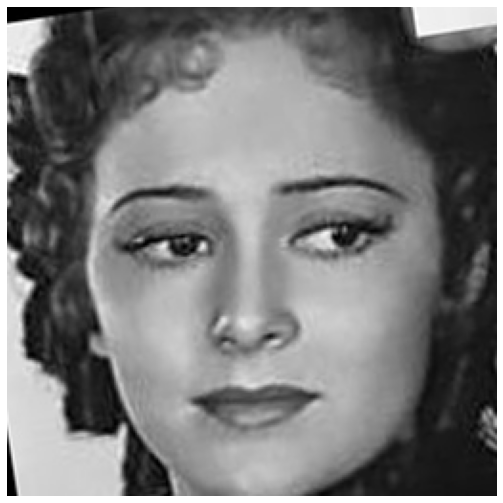

filename: gender_dataset/val/female/10743_MerylStreep_53_f.jpg, male_proba: 0.0010044025257229805


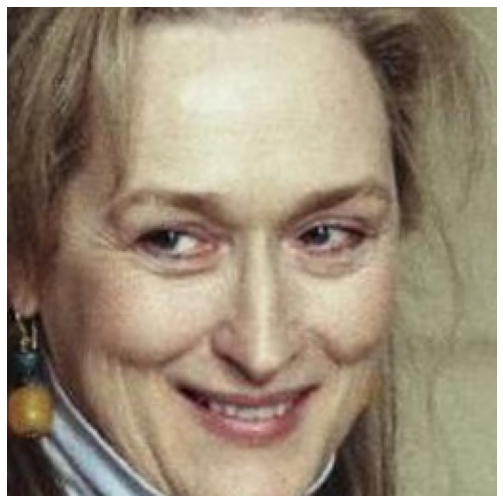

filename: gender_dataset/val/male/2290_RodTaylor_81_m.jpg, male_proba: 0.9998443126678467


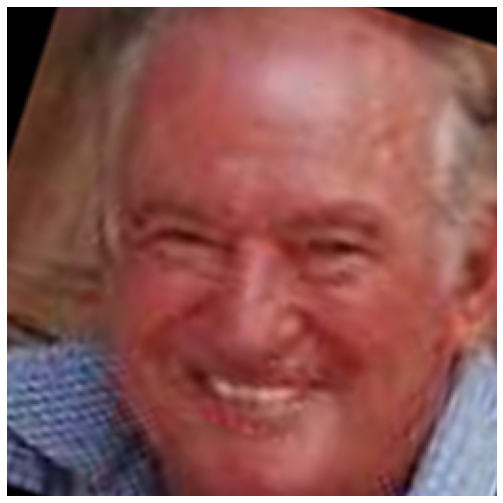

filename: gender_dataset/val/female/10946_DaliahLavi_30_f.jpg, male_proba: 0.06457550078630447


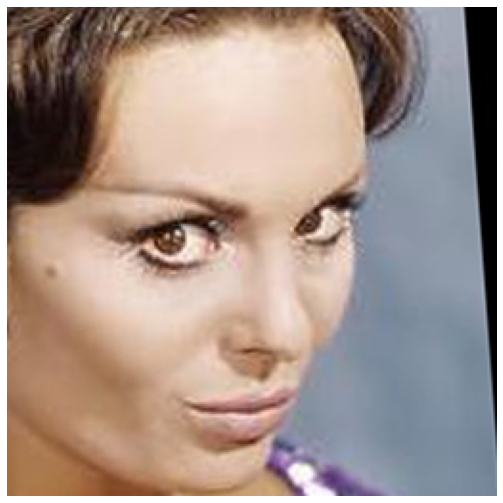

filename: gender_dataset/val/male/3230_GeneHackman_56_m.jpg, male_proba: 0.9999998807907104


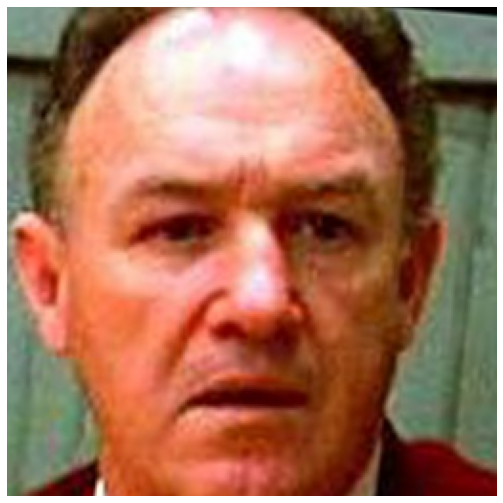

filename: gender_dataset/val/female/12224_IsabelleAdjani_21_f.jpg, male_proba: 2.7157757358509116e-05


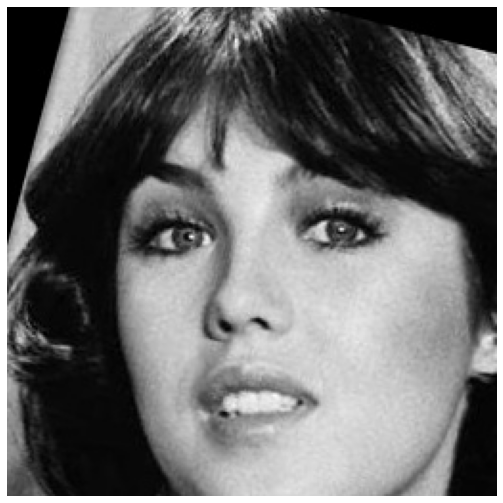

filename: gender_dataset/val/male/3991_BurtReynolds_55_m.jpg, male_proba: 0.9969381093978882


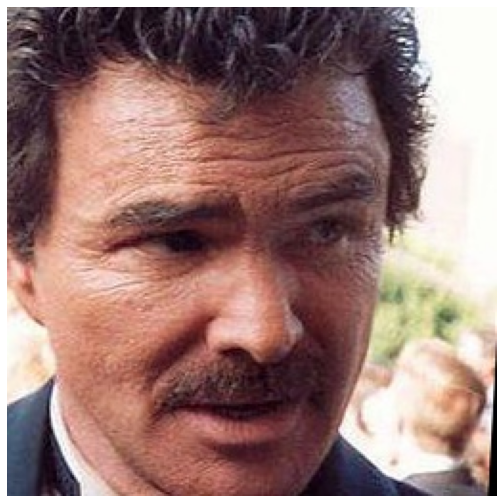

filename: gender_dataset/val/female/10624_LindaEvans_49_f.jpg, male_proba: 0.002707639941945672


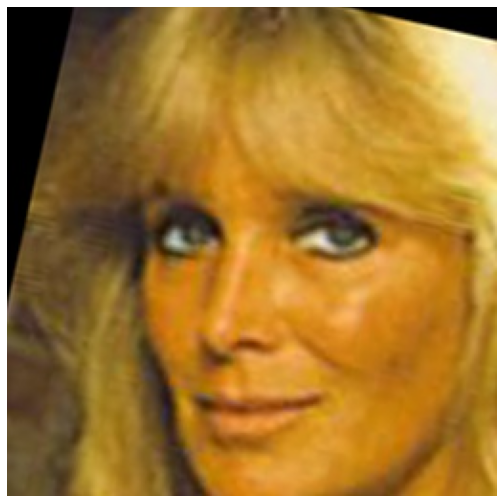

filename: gender_dataset/val/male/16203_BillCosby_72_m.jpg, male_proba: 0.9476858377456665


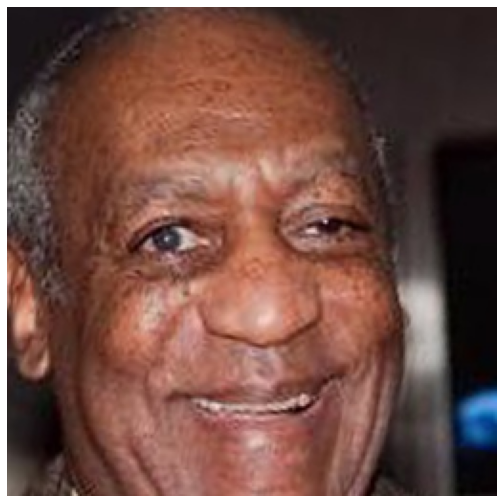

filename: gender_dataset/val/male/3642_OmarSharif_37_m.jpg, male_proba: 0.9999951124191284


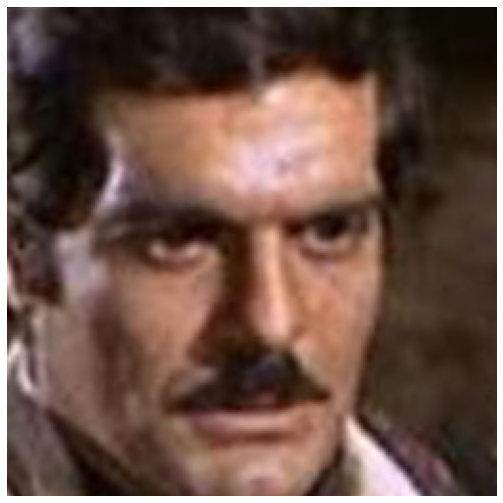

In [44]:
val_filenames = [pair[0] for pair in val_dataset.samples]
for file in np.random.choice(val_filenames, 10):
    male_proba = predict_male_proba(model_ft, file)
    print ("filename: {}, male_proba: {}".format(file, male_proba))
    show_image(cv2.imread(file))

# Look at the mistakes

filename: ./gender_dataset/val/female/10225_KathyBates_47_f.jpg, male_proba: 0.7081947922706604


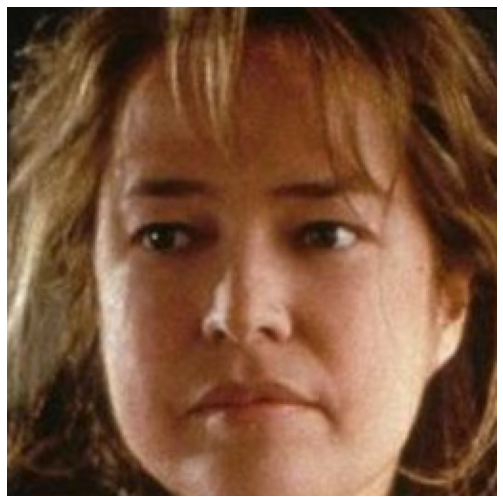

filename: ./gender_dataset/val/female/10226_KathyBates_47_f.jpg, male_proba: 0.9240124225616455


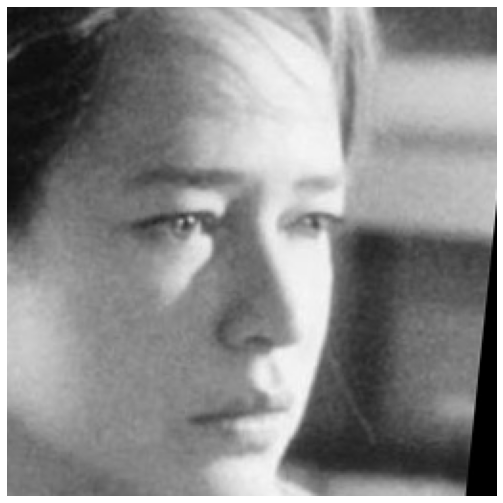

filename: ./gender_dataset/val/female/10234_KathyBates_57_f.jpg, male_proba: 0.992456316947937


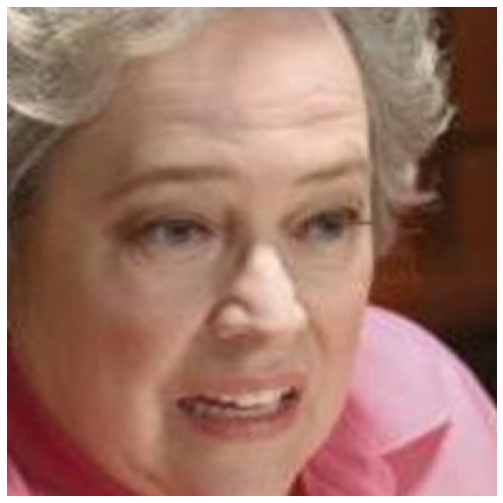

filename: ./gender_dataset/val/female/10236_KathyBates_56_f.jpg, male_proba: 0.9809540510177612


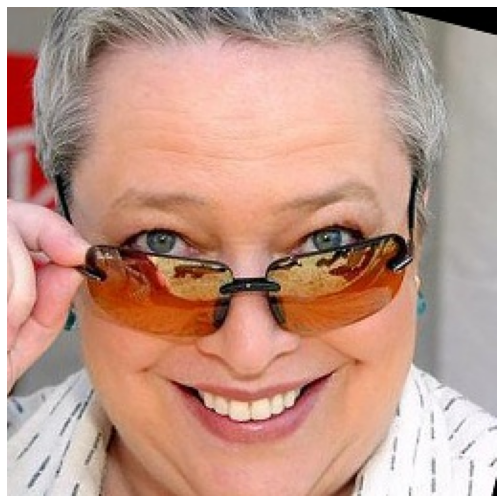

filename: ./gender_dataset/val/female/10604_LindaEvans_22_f.jpg, male_proba: 0.582953929901123


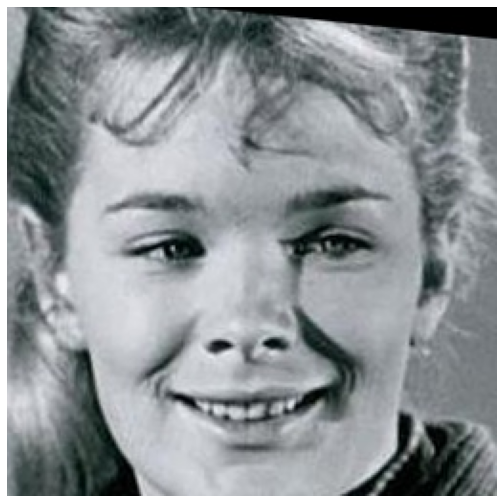

filename: ./gender_dataset/val/female/11096_JodieFoster_29_f.jpg, male_proba: 0.7369005680084229


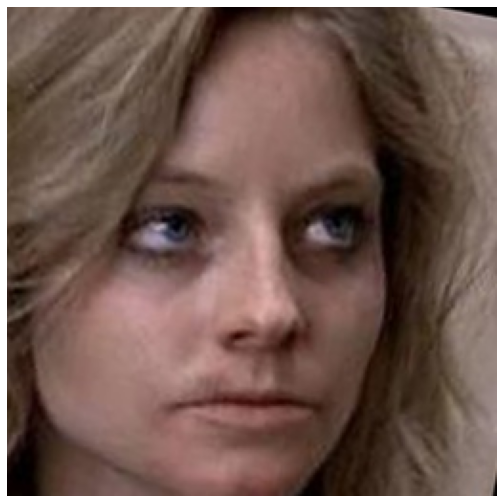

filename: ./gender_dataset/val/female/11515_JulieChristie_41_f.jpg, male_proba: 0.999852180480957


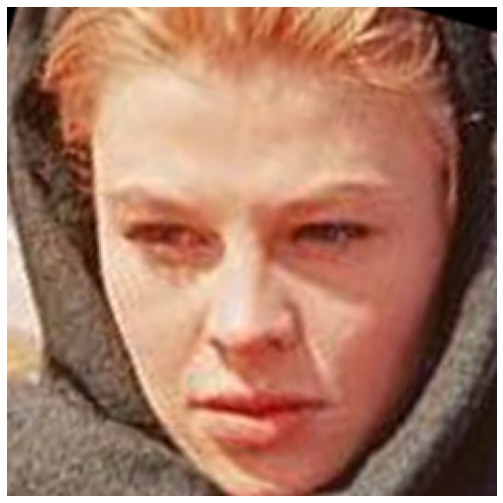

filename: ./gender_dataset/val/female/11958_AngelaLansbury_33_f.jpg, male_proba: 0.8737414479255676


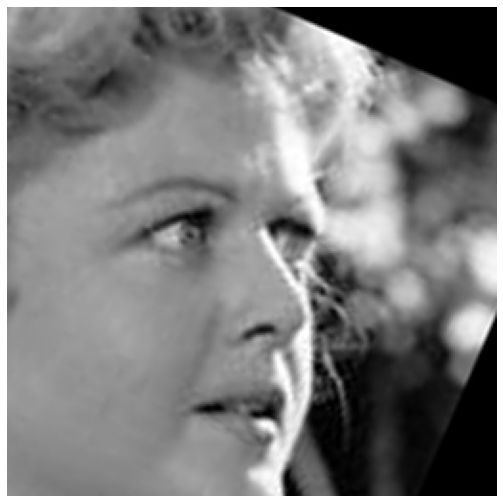

filename: ./gender_dataset/val/female/11968_AngelaLansbury_55_f.jpg, male_proba: 0.8420894742012024


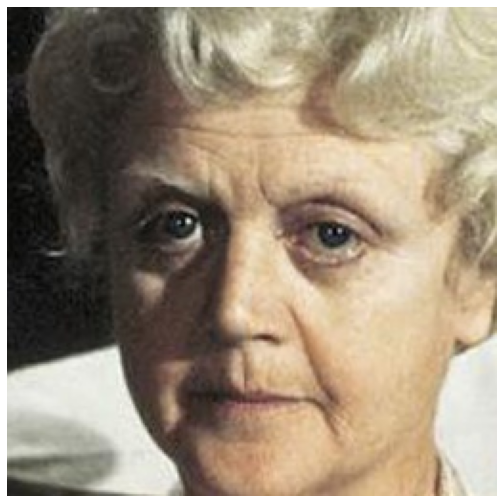

filename: ./gender_dataset/val/female/11984_AngelaLansbury_80_f.jpg, male_proba: 0.9880470037460327


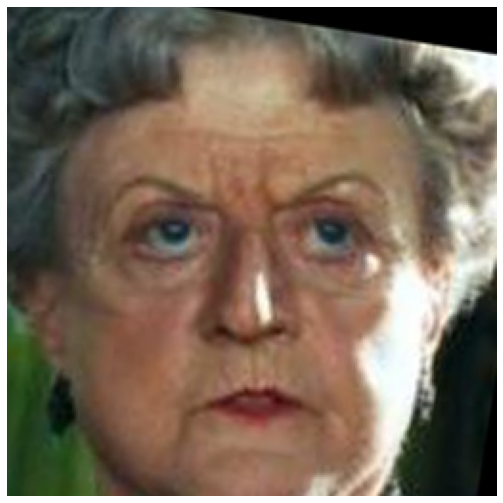

In [45]:
for i, (file, label) in enumerate(checkpoint["gender_mistakes_filenames"]):
    if i == 10:
        break
    file = file.replace("/data4/made/gender_dataset/", "./gender_dataset/")
    male_proba = predict_male_proba(model_ft, file)
    print ("filename: {}, male_proba: {}".format(file, male_proba))
    show_image(cv2.imread(file))